In [1]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler


__author__ = 'Marcel Baltruschat'
__copyright__ = 'Copyright © 2020-2023'
__license__ = 'MIT'
__version__ = '1.1.0'
__additional__ = 'Changes & adaptions by Alexander Minidis'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation
sns.set(palette='bright')  # Set bright style for Seaborn
PandasTools.RenderImagesInAllDataFrames()  # Render mol images


/tmp/ipykernel_1165/3073574611.py:23: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Cross-Validation Class

In [2]:
"""
Copyright © 2019 Marcel Baltruschat

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files 
(the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do 
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

Source: https://github.com/czodrowskilab/gafp/tree/master/fp
"""
class CVRegressor:
    """
    Regressor that predicts based on predictions of k models from k-fold CV.
    Accepts any Scikit-learn-like regressor as base regressor. It trains k models
    by doing k-fold CV and stores the individual models. Predictions
    on new samples are done by calculating mean predictions from all models.
    
    Parameters
    ----------
    est : Any
        Scikit-learn (-like) regressor object. Must contain .fit() and .predict() methods.
    params : Dict[str, Any]
        Regressor parameters
    n_folds : int
        Number of folds for k-fold
    shuffle : bool
        Shuffling of data for CV
    """
    __slots__ = ('est', 'params', 'models', 'n_folds', 'shuffle', 'cv_scores')

    def __init__(self, est: Any, params: Dict[str, Any], n_folds: int = 5, shuffle: bool = True):
        self.est = est
        self.params = params
        self.models = []
        self.n_folds = n_folds
        self.shuffle = shuffle
        self.cv_scores = ddict(list)

    def fit(self, x_data: np.ndarray, y_data: np.ndarray, scoring_funcs: List=(), random_state: int=None) -> None:
        """
        Build a regressor consisting of k-models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Training data
        y_data : numpy.ndarray
            Target values
        scoring_funcs : list
            List of scoring functions to use for evaluating cross-validation results
        random_state : int
            Integer to use for seeding the k-fold split
        """

        kf = KFold(n_splits=self.n_folds, shuffle=self.shuffle, random_state=random_state)
        kf = kf.split(X=x_data, y=y_data)

        # Fit k models and store them
        for train_index, test_index in kf:
            est_tmp = self.est(**self.params)
            est_tmp.fit(x_data[train_index], y_data[train_index])
            if scoring_funcs:
                test_pred = est_tmp.predict(x_data[test_index])
                for sf in scoring_funcs:
                    self.cv_scores[str(sf).split(' ')[1]].append(sf(y_data[test_index], test_pred))
            self.models.append(est_tmp)

    def predict(self, x_data: np.ndarray) -> np.ndarray:
        """
        Predict using prediction mean from k models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Samples to predict
        
        Returns
        -------
        numpy.ndarray
            Predicted values
        """

        return np.mean([m.predict(x_data) for m in self.models], axis=0)

## function

In [3]:
def rmse(y_true, y_pred):
    """Helper function"""
    return mean_squared_error(y_true, y_pred, squared=False)

def calc_stats_str(pka1, pka2):
    """Calculates R², MAE and RMSE for two iterables of floats or integers"""
    assert len(pka1) == len(pka2), "Both iterables must have the same length"
    return f'R²: {r2_score(pka1, pka2):.3f}\n' \
           f'MAE: {mean_absolute_error(pka1, pka2):.3f}\n' \
           f'RMSE: {rmse(pka1, pka2):.3f}'

def train_cv_model(est_cls, x_data, y_data, params, random_state,
                   cv=5, shuffle=True, scaled=False, scoring_funcs=(mean_absolute_error, rmse, r2_score)):
    """Scales the training data if wanted and trains a cross-validated model"""
    scaler = None
    if scaled:
        scaler = StandardScaler()
        x_data = scaler.fit_transform(x_data)
    cvr = CVRegressor(est=est_cls, params=params, n_folds=cv, shuffle=shuffle)
    cvr.fit(x_data, y_data, scoring_funcs=scoring_funcs, random_state=random_state)
    return cvr, scaler

def calc_x_data(df, mols, radius=3, nBits=2048):  
    """Calculates fingerprints for Rdkit object, combines with previous calculcated descriptors"""

    fmorgan = [] 
    for mol in mols:
        # descs not calculated here
        fmorgan.append(Chem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useFeatures=True))
    descs = df.values # only throughput to stick to original code
    fmorgan = np.array(fmorgan)
    return descs, fmorgan, np.concatenate([descs, fmorgan], axis=1)

def duplicates(X, round=None) -> list:
    """Drop duplicate columns in dataframe

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param round: decimal point used for rounding. If set the dataframe is scaled with MinMaxScaler \
    and rounded to the given precision, afterward duplicates are removed. This allows to drop duplicates avoiding \
    floating point precision issues
    :type round: int
    :return: list of columns that are duplicates
    """

    _X = X.copy()
    if round is not None:
        scaler = MinMaxScaler()
        _X = pd.DataFrame(scaler.fit_transform(X_),
                          columns=_X.columns,
                          index=_X.index)
        _X = _X.round(round)
    return _X.columns[_X.T.duplicated()].tolist()


def correlated(X, threshold=0.95) -> list:
    """Decorrelate dataframe by finding which columns shall \
    be removed to achieve correlation level below threshold

    :param X: input dataframe
    :type X: pandas.core.frame.DataFrame
    :param threshold: maximum correlation allowed in the frame X
    :type threshold: float
    :return: list of columns to prune in order to achieve desired decorrelation level
    """

    X_ = X.copy()
    N = X_.shape[1]
    corr = X_.corr().abs()

    to_drop = set()
    for i in range(N - 1):
        for j in range(i + 1, N):
            if corr.iloc[i][j] > threshold and i not in to_drop:
                to_drop.add(j)
    return [X_.columns[i] for i in to_drop]

---
## Loading Precombined Dataset

In [4]:
# read pickle file
pickle_input = "datasets_AM/all_data_cleaned_properties.pkl"
print("\nReading pickle file: ", pickle_input)
with open(pickle_input, "rb") as f:
    df_full = pickle.load(f)
print(df_full.shape) 
df=df_full.drop(['Source', 'ISO_SMI', 'marvin_pKa', 'ID'], axis=1,  errors="ignore")
df.describe()


Reading pickle file:  datasets_AM/all_data_cleaned_properties.pkl
(13219, 153)


,pKa,MolLogP,MolMR,MolWt,NHOHCount,NOCount,FractionCSP3,RingCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
count,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,...,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000,13219.000
mean,6.980,2.024,74.685,276.703,1.798,4.379,0.371,2.286,0.172,0.461,...,0.030,0.024,0.476,1.722,0.024,0.001,0.001,0.009,1.250,0.730
std,2.565,2.047,36.311,135.380,1.503,2.565,0.278,1.525,0.560,0.768,...,0.179,0.162,0.675,1.325,0.155,0.023,0.044,0.100,2.000,1.559
min,1.700,-8.185,6.670,27.026,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.750,0.747,45.160,165.192,1.000,3.000,0.154,1.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,7.260,2.006,68.107,251.333,1.000,4.000,0.333,2.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,9.080,3.417,99.747,369.368,3.000,6.000,0.500,3.000,0.000,1.000,...,0.000,0.000,1.000,3.000,0.000,0.000,0.000,0.000,2.000,1.000
max,13.000,13.099,333.040,1216.662,12.000,23.000,1.000,9.000,6.000,5.000,...,3.000,3.000,6.000,8.000,2.000,1.000,2.000,2.000,27.000,28.000


### remove noise etc

In [5]:
# normally done on training data only
print (f"Number of features at start: {df.shape[1]}, number of samples: {df.shape[0]}")
nan_columns = df.columns[df.isna().any()].tolist()
df = df.drop(nan_columns, axis=1)
print("Removed columns:", nan_columns)
zero_std = df.std()[df.std() == 0].index
display(f"Zero std columns: {len(zero_std)}")
df = df[df.columns.difference(zero_std)]
dupes = duplicates(df, round=3)
display(f"Duplicate columns: {len(dupes)}")
df = df[df.columns.difference(dupes)]
print("Removed columns:", dupes)
high_corr = correlated(df, threshold=0.99)
display(f"Correlated features: {len(high_corr)}")
df = df[df.columns.difference(high_corr)]
print (f"Number of features at the end: {df.shape[1]}, number of samples: {df.shape[0]}")

Number of features at start: 149, number of samples: 13219
Removed columns: []


'Zero std columns: 5'

'Duplicate columns: 4'

Removed columns: ['MQN12', 'MaxEStateIndex', 'NHOHCount', 'NumRotatableBonds']


'Correlated features: 7'

Number of features at the end: 133, number of samples: 13219


## Show p<i>K</i><sub>a</sub> Distribution

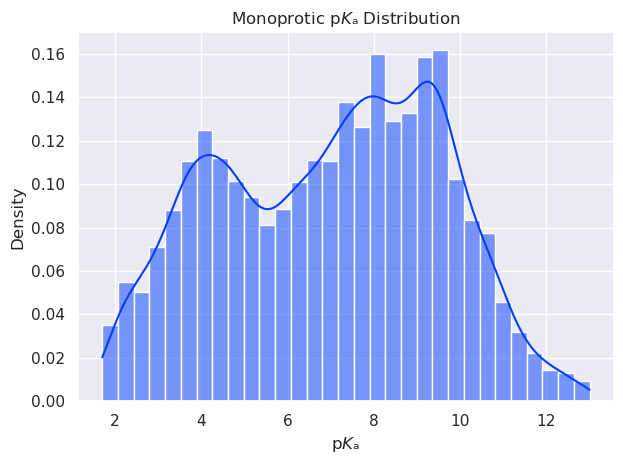

In [6]:
sns_major, sns_minor = map(int, sns.__version__.split('.')[:2])
plt.figure(dpi=100)
if sns_major > 0 or sns_minor >= 11:
    sns.histplot(df.pKa, kde=True, stat='density')
else:
    sns.distplot(df.pKa)
plt.ylabel('Density')
plt.xlabel('p$K$ₐ')
plt.title('Monoprotic p$K$ₐ Distribution')
plt.tight_layout()
plt.show()

## Calculating Fingerprints (descriptors previously done and combine all)

In [7]:
df_full['ROMol'] = df_full['ISO_SMI'].apply(Chem.MolFromSmiles)
descs_df = df.drop(['pKa'], axis=1,  errors="ignore")
radius = 2
nBits = 2048
# reusing the function almost as is but skipping descs, but leaving the option to add them later
descs, fmorgan, descs_fmorgan = calc_x_data(descs_df, df_full.ROMol, radius=radius, nBits=nBits)


---
## Training Random Forest
#### Using the following training sets with 5-fold cross-validation (shuffled)
1. RDKit descriptor set
2. Fmorgan
3. RDKit descriptor set + Fmorgan
4. RDKit descriptor set (standard scaled)
5. Fmorgan (standard scaled)
6. RDKit descriptor set + Fmorgan (standard scaled)

### Prepare for Training

In [8]:
seed = 42

est_jobs = -1
verbose = False

y_train = df.pKa.values
desc_sets = list(zip([descs, fmorgan, descs_fmorgan] * 2, 
                     [False] * 3 + [True] * 3, 
                     ['Desc', 'FMorgan', 'Desc_FMorgan', 'Desc_scaled', 'FMorgan_scaled', 'Desc_FMorgan_scaled']))

models = ddict(odict)  # estimator => training set => [model, scaler]

def train_all_sets(est_cls, params, name):
    for x_data, scaled, set_name in desc_sets:
        models[name][set_name] = train_cv_model(est_cls, x_data, y_train, params, seed, scaled=scaled)
        # outch, this works in jupyter, but is not very clean it should be returned ....

In [9]:
def generate_score_board(name):
    print(f'{name} CV Scores:')
    for ts, (m, s) in models[name].items():
        print(f'\t{ts}')
        for k, v in m.cv_scores.items():
            print(f'\t\t- {k}: {np.mean(v):.3f} ± {np.std(v):.3f}')

---
### RandomForest

In [12]:
est_cls = RandomForestRegressor
rf_params = dict(n_estimators=10, n_jobs=est_jobs, verbose=verbose, random_state=seed)
name = 'RandomForest (n_estimators=1000)'

train_all_sets(est_cls, rf_params, name)

In [13]:
generate_score_board(name)

RandomForest (n_estimators=1000) CV Scores:
	Desc
		- mean_absolute_error: 1.142 ± 0.019
		- rmse: 1.676 ± 0.029
		- r2_score: 0.573 ± 0.017
	FMorgan
		- mean_absolute_error: 1.033 ± 0.022
		- rmse: 1.599 ± 0.033
		- r2_score: 0.611 ± 0.016
	Desc_FMorgan
		- mean_absolute_error: 1.044 ± 0.019
		- rmse: 1.579 ± 0.023
		- r2_score: 0.621 ± 0.015
	Desc_scaled
		- mean_absolute_error: 1.141 ± 0.016
		- rmse: 1.674 ± 0.027
		- r2_score: 0.574 ± 0.017
	FMorgan_scaled
		- mean_absolute_error: 1.033 ± 0.022
		- rmse: 1.599 ± 0.033
		- r2_score: 0.611 ± 0.016
	Desc_FMorgan_scaled
		- mean_absolute_error: 1.043 ± 0.018
		- rmse: 1.577 ± 0.021
		- r2_score: 0.622 ± 0.013


---
## Predicting external testsets

In [20]:
# read pickle file
pickle_input = "datasets_AM/novartis_cleaned_properties.pkl"
print("\nReading pickle file: ", pickle_input)
with open(pickle_input, "rb") as f:
    novartis_testset = pickle.load(f)
print(novartis_testset.shape)

desc_nov = novartis_testset.reindex(columns=df.columns) # use only columns after cleaning from training set
desc_nov = desc_nov.drop(['pKa'], axis=1,  errors="ignore")



Reading pickle file:  datasets_AM/novartis_cleaned_properties.pkl
(280, 153)


In [21]:
if 'ROMol' not in novartis_testset.columns:
    novartis_testset['ROMol'] = novartis_testset['ISO_SMI'].apply(Chem.MolFromSmiles)

In [26]:
descs_nov, fmorgan_nov, descs_fmorgan_nov = calc_x_data(desc_nov, novartis_testset.ROMol, radius=radius, nBits=nBits)

#### Predicting with all models

In [27]:
def test_all_models(desc, fp, both, true_vals):
    res = ddict(list)
    for conf, desc_set in models.items():
        for ts, (m, s) in desc_set.items():
            
            x_test = both if ts.startswith('Desc_FMorgan') else fp if ts.startswith('FMorgan') else desc
            if s:
                x_test = s.transform(x_test)
            pred = m.predict(x_test)
            res['Model'].append(conf)
            res['Trainset'].append(ts)
            res['MAE'].append(mean_absolute_error(true_vals, pred))
            res['RMSE'].append(rmse(true_vals, pred))
            res['R2'].append(r2_score(true_vals, pred))
    return pd.DataFrame(res)

In [ ]:
print(fmorgan_nov)

In [28]:
res_df_nov = test_all_models(descs_nov, fmorgan_nov, descs_fmorgan_nov, novartis_testset.pKa)

In [29]:
res_df_nov

,Model,Trainset,MAE,RMSE,R2
0,RandomForest (n_estimators=1000),Desc,0.891,1.095,0.774
1,RandomForest (n_estimators=1000),FMorgan,0.687,0.910,0.844
2,RandomForest (n_estimators=1000),Desc_FMorgan,0.801,1.007,0.809
3,RandomForest (n_estimators=1000),Desc_scaled,0.884,1.082,0.779
4,RandomForest (n_estimators=1000),FMorgan_scaled,0.687,0.910,0.844
5,RandomForest (n_estimators=1000),Desc_FMorgan_scaled,0.795,1.005,0.810


In [31]:
# read pickle file
pickle_input = "datasets_AM//avlilumove_cleaned_properties.pkl"
print("\nReading pickle file: ", pickle_input)
with open(pickle_input, "rb") as f:
    avlilumove_testset = pickle.load(f)
print(avlilumove_testset.shape)

descs_avl = avlilumove_testset.reindex(columns=df.columns) # use only columns after cleaning from training set
descs_avl = descs_avl.drop(['pKa'], axis=1,  errors="ignore")
if 'ROMol' not in avlilumove_testset.columns:
    avlilumove_testset['ROMol'] = avlilumove_testset['ISO_SMI'].apply(Chem.MolFromSmiles)

descs_avl, fmorgan_avl, descs_fmorgan_avl = calc_x_data(descs_avl, avlilumove_testset.ROMol, radius=radius, nBits=nBits)


Reading pickle file:  datasets_AM//avlilumove_cleaned_properties.pkl
(280, 153)


In [32]:
res_df_avl = test_all_models(descs_avl, fmorgan_avl, descs_fmorgan_avl, avlilumove_testset.pKa)

In [33]:
res_df_avl

,Model,Trainset,MAE,RMSE,R2
0,RandomForest (n_estimators=1000),Desc,0.891,1.095,0.774
1,RandomForest (n_estimators=1000),FMorgan,0.687,0.910,0.844
2,RandomForest (n_estimators=1000),Desc_FMorgan,0.801,1.007,0.809
3,RandomForest (n_estimators=1000),Desc_scaled,0.884,1.082,0.779
4,RandomForest (n_estimators=1000),FMorgan_scaled,0.687,0.910,0.844
5,RandomForest (n_estimators=1000),Desc_FMorgan_scaled,0.795,1.005,0.810
